___
## **Imports Libraries**
___

In [127]:
# Dataframe libraries
import numpy as np 
import pandas as pd
import geopandas as gpd

# Misc Libraries
from typing import Optional
import os

# Hypothesis testing libray
from scipy.stats import pearsonr
from mlxtend.preprocessing import standardize

# plotting libraries
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns 
import ipywidgets as widgets

# Set style of visualizations
sns.set_style('darkgrid')

___
## **Load Files** 
___

In [128]:
cwd = os.getcwd()
file = 'Datasets'
filepath = os.path.join(cwd, file, 'UsArrests.csv')
df = pd.read_csv(filepath)

filepath = os.path.join(cwd, 'us-states.json')
geoData = gpd.read_file(filepath)

filepath = os.path.join(cwd, 'state_codes.csv')
state_code_df = pd.read_csv(filepath)

___
## **Dataset Attributes**
___

In [129]:
df.size

250

In [130]:
df.shape

(50, 5)

In [131]:
df.axes

[RangeIndex(start=0, stop=50, step=1),
 Index(['City', 'Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')]

In [132]:
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [133]:
df.tail()

,City,Murder,Assault,UrbanPop,Rape
45,Virginia,8.5,156,63,20.7
46,Washington,4.0,145,73,26.2
47,West Virginia,5.7,81,39,9.3
48,Wisconsin,2.6,53,66,10.8
49,Wyoming,6.8,161,60,15.6


___
## **Dataset Pre-processing**
___

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


#### 1. **Duplicated Values**

In [135]:
total_dups = df.duplicated().sum()

print(f"Total number of duplicates: {total_dups}")

Total number of duplicates: 0


#### 2. **Null Values**

In [136]:
# Total number of null values
total_null_values = np.count_nonzero(df.isnull())
print(f"The total number of null values: {total_null_values}")

The total number of null values: 0


#### 3. **Outlier Values**

In [137]:
def outlier_imputation(column: str, dataframe: Optional[pd.DataFrame] = df, drop_outliers: Optional[bool] = False):
    """
    A function that is responsible for imputing the outliers of the column argument passed in the dataframe 
    object passed as an argument. Default dataframe object is the autombile_df.

    Args:
        column: string
        Name of a numeric column in the dataframe 

        df: dataframe
        A pandas dataframe object that contains numeric features. If None, automobile_df is passed
        at function call. 

        drop_outliers: Drops the outliers of the dataframe, default is False
    
    Return:
        None
    """
    # Store the original column values
    original_column = dataframe[column]

    # Measure the first quantile of the column
    q1 = dataframe[column].quantile(0.25)

    # Measure the third wuantile of the column
    q3 = dataframe[column].quantile(0.75)

    # Find the IQR
    IQR = q3 - q1

    # Using the IQR, find the upper and lower outliers
    upper = (dataframe[column] > q3 + (IQR * 1.5))
    lower = (dataframe[column] < q1 - (IQR * 1.5))

    # Store the outliers of the column as a series
    outliers = dataframe[column][upper | lower]

    # Store the orginal columns measures of central tendency
    original_mean = dataframe[column].mean()
    original_median = dataframe[column].median()
    original_mode = int(dataframe[column].mode().loc[0])
    original_std = dataframe[column].std()
    
    print(f"Column name: {column}")
    print(f"Total number of outliers: {len(outliers)}")
    print(f"Skewness: {dataframe[column].skew()}")
    print(f"Mean value: {original_mean}")
    print(f"Standard deviation value: {original_std}")
    print(f"Median value: {original_median}")
    print(f"Mode value: {original_mode}\n")

    # Return the frequency table of the column and normalize 
    # the values to return percentage composition of values for the column
    freq_percentage = dataframe[column].value_counts(normalize=True) * 100

    def dist_plot(original_col, new_col):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        sns.histplot(original_col, ax=ax[0], kde=True)
        ax[0].set_title(f'Original Distribution for {column} column', weight='bold')
        sns.histplot(new_col, ax=ax[1], kde=True)
        ax[1].set_title(f'New Distribution for {column} column', weight='bold')
        plt.show()


    if len(outliers) == 0:
        pass

    elif drop_outliers == True:
        dataframe.drop(index=outliers.index, inplace=True)
        print("\nOutliers have been dropped")
        print(f"New mean dropping outliers: {dataframe[column].mean()}")
        print(f"New standard deviation dropping outliers: {dataframe[column].std()}")
        print(f"Skweness: {dataframe[column].skew()}")

        dist_plot(original_column, dataframe[column])

    elif float(freq_percentage.iloc[0]) > 50:
        dataframe.loc[outliers.index, column] = original_mode
        print("\nMode has been used to impute the outliers.")
        print(f"New mean using mode value: {dataframe[column].mean()}")
        print(f"New standard deviation mode value: {dataframe[column].std()}")
        print(f"Skweness: {dataframe[column].skew()}")


        dist_plot(original_column, dataframe[column])

    elif (dataframe[column].skew() > 0.5) | (dataframe[column].skew() < -0.5):
        dataframe.loc[outliers.index, column] = dataframe[column].median()
        print("\nMedian has been used to impute the outliers.")
        print(f"New mean using median value: {dataframe[column].mean()}")
        print(f"New standard deviation median value: {dataframe[column].std()}")
        print(f"Skweness: {dataframe[column].skew()}")

        
        dist_plot(original_column, dataframe[column])

    else:
        upper_limit = dataframe[column].mean() + (3 * dataframe[column].std())
        lower_limit = dataframe[column].mean() - (3 * dataframe[column].std())

        new_column = (
            np.where(dataframe[column] > upper_limit
                 , upper
                 , np.where(dataframe[column] < lower_limit, lower_limit, dataframe[column]))
        )
        dataframe[column] = new_column
        print(f"{column}:")
        print(f"\nNew mean using cap limit: {dataframe[column].mean()}")
        print(f"New standard deviation cap limit: {dataframe[column].std()}")
        print(f"Skweness: {dataframe[column].skew()}")

        dist_plot(original_column, dataframe[column])


Column name: Murder
Total number of outliers: 0
Skewness: 0.3939564324470969
Mean value: 7.788
Standard deviation value: 4.355509764209288
Median value: 7.25
Mode value: 2

Column name: Assault
Total number of outliers: 0
Skewness: 0.2344095905541752
Mean value: 170.76
Standard deviation value: 83.33766084001707
Median value: 159.0
Mode value: 120

Column name: UrbanPop
Total number of outliers: 0
Skewness: -0.22600946066699326
Mean value: 65.54
Standard deviation value: 14.474763400836785
Median value: 66.0
Mode value: 66

Column name: Rape
Total number of outliers: 2
Skewness: 0.8012004849360391
Mean value: 21.231999999999992
Standard deviation value: 9.36638453105965
Median value: 20.1
Mode value: 14


Median has been used to impute the outliers.
New mean using median value: 20.226
New standard deviation median value: 7.948605576592972
Skweness: 0.5320484771324427


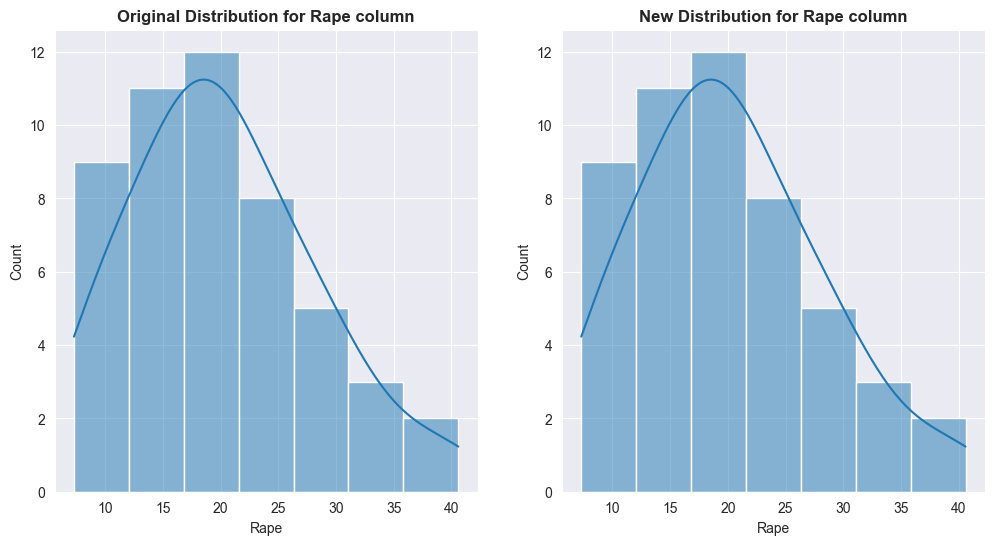

In [138]:
for column in df.select_dtypes(include='number').columns:
    outlier_imputation(column, df)

`NOTE`:

* We only have outliers in the Rape column. We need to find out what these values are and what caused them to exist in our dataset. Kirstie Sequitin (2023) explains that some of the more common reasons that we find outliers within our datasets includes human error while manually entering data, such as a typo, sampling errors that arise from unintended mutations of a dataset and measurement errors as a result of instrumental error just to name a few.

___
## **Exploratory Data Analysis**
___

#### 1. **Summary Statistics**

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [140]:
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,20.226000
std,4.35551,83.337661,14.474763,7.948606
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.050000
75%,11.25000,249.000000,77.750000,25.725000
max,17.40000,337.000000,91.000000,40.600000


#### 2. **Data Visualization**

##### a) **What is the distribution and relationships between the numeric variables of the dataset**

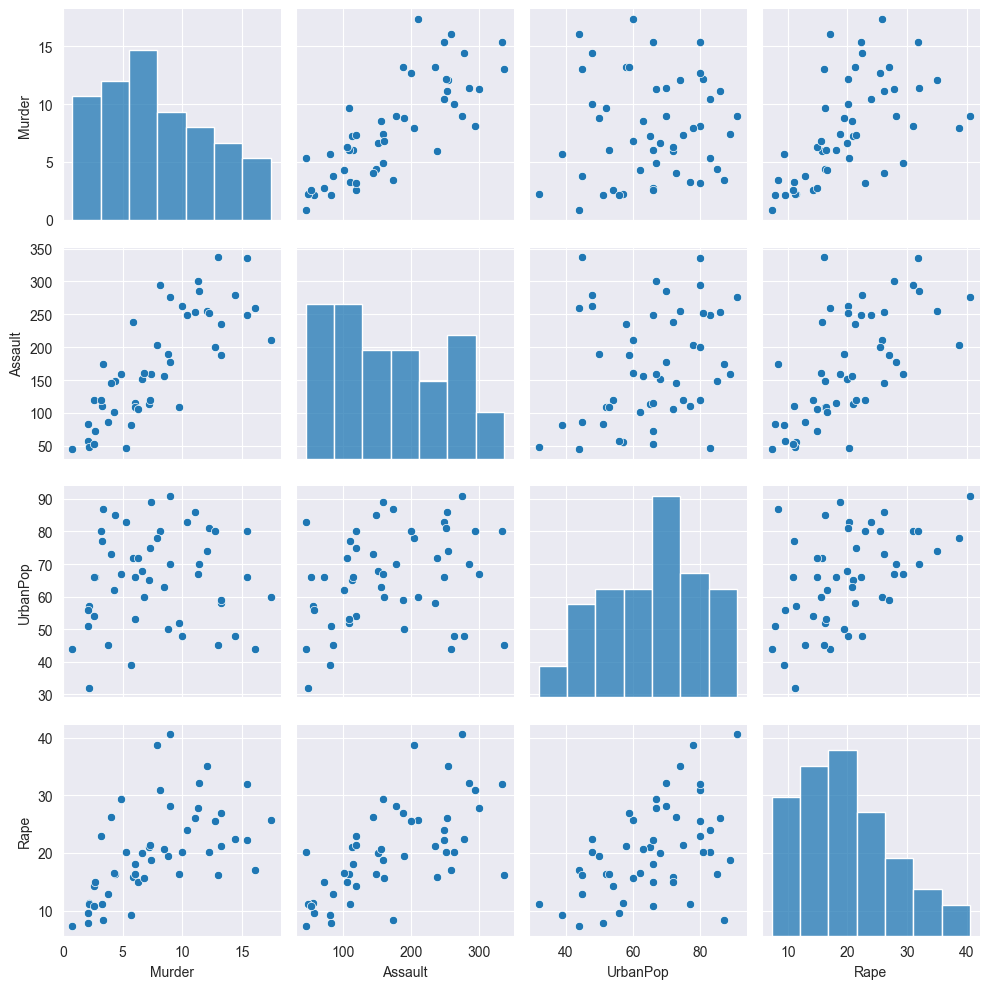

In [141]:
# Find the distribution of all the numeric variables of the dataset
sns.pairplot(df)
plt.tight_layout()
plt.show()

`NOTE`:

* In an article on _Geeks For Geeks_ (2024), the purpose of the pairplot is to visualize the relationship between the numeric variables and distribution of the numbers in the feature.

* Some interesting information gleaned from the relationship between the murder and urban population features is that there is no correlation. A correlation matrix can be used to return a more clearer picture on the features relationships. 

* We can also see from the graph that there is a strong correlation between the murder and assault features for each city. 

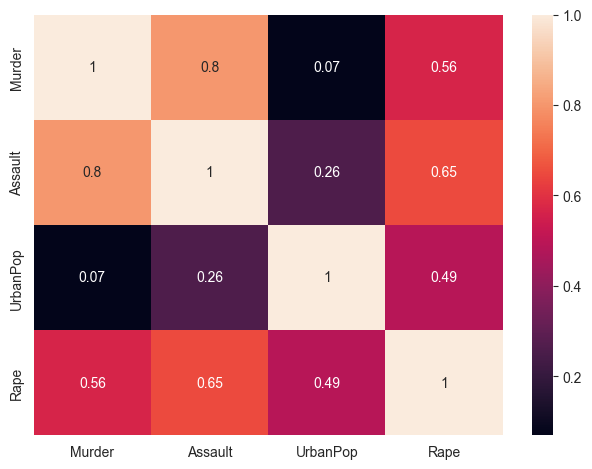

In [142]:
correlation_df = df.select_dtypes(include='number').corr()
sns.heatmap(correlation_df, annot=True)
plt.tight_layout()
plt.show()

`NOTE`:

* The initial assumption is that there is no correlation between urban population and the violent crimes within the each state

* There is an assumed strength in the correlation between the murder and assault features. In his book, Data Simplification, Jules J. Berman (2016), explains that a pearson correlation coefficient of 0.8 or greater represents a strong relationship between the two features. 

##### b) **What is the proportionality of the violent crimes per City?**

`NOTE`:

* According to an article by Suvarna Gawali on Analytics Vidhya, skewness is a statistical measure that assesses the asymmetry of a probability distribution. It quantifies the extent to which the data is skewed or shifted to one side. Furthermore, he goes on to explain that a skweness score between -0.5 to 0.5 represents a normal(gaussian) distribution. (Gawali, 2024)

* The reason we need to know and understand the skewness of a feature, is because we intend to compare the features per city to understand the ratio of the crimes within a city. For this purpose, as explained by Zakaraia Jaadi (2023), Data standardization comes into the picture when features of the input data set have large differences between their ranges, or simply when they are measured in different units (e.g., pounds, meters, miles, etc.).

In [143]:
# Confirm the skewness of each feature
for feature in df.select_dtypes(include='number'):
    print(f"Skewness of {feature} feature is {df[feature].skew()}")

Skewness of Murder feature is 0.3939564324470969
Skewness of Assault feature is 0.2344095905541752
Skewness of UrbanPop feature is -0.22600946066699326
Skewness of Rape feature is 0.5320484771324427


`NOTE`:

* Due to skewness being found within the range of -0.5 and 0.5, we can standerdise the feature values. This is because standerdization is most useful for normal distributions (Jaadi, 2023)

In [144]:
# Use minmax to standardise the features

# Set a blank dictionary
dct = {}
for feature in df.select_dtypes(include='number').columns:
    # Scale the feature and store as a variable
    scaled_data = standardize(df[feature].to_numpy(), columns = [0])

    # Flatten the nested list using list comprehension. Multiply negative values by -1 to convert them into a positive
    # number.
    scaled_data_flattened = [element * -1 if element < 0 else element for sublist in scaled_data for element in sublist]

    # Add the variable of the feature as a key: value pair with the feature as the key and the scaled data as a
    # list, as the value.
    dct.update({feature: scaled_data_flattened})

# Create a standerdized dataframe
df2 = pd.DataFrame(dct)

In [145]:
df2.tail()

,Murder,Assault,UrbanPop,Rape
45,0.165131,0.178909,0.177259,0.060239
46,0.878533,0.312242,0.520612,0.759209
47,0.484260,1.087999,1.852151,1.388536
48,1.203228,1.427393,0.032102,1.197908
49,0.229142,0.118303,0.386621,0.587898


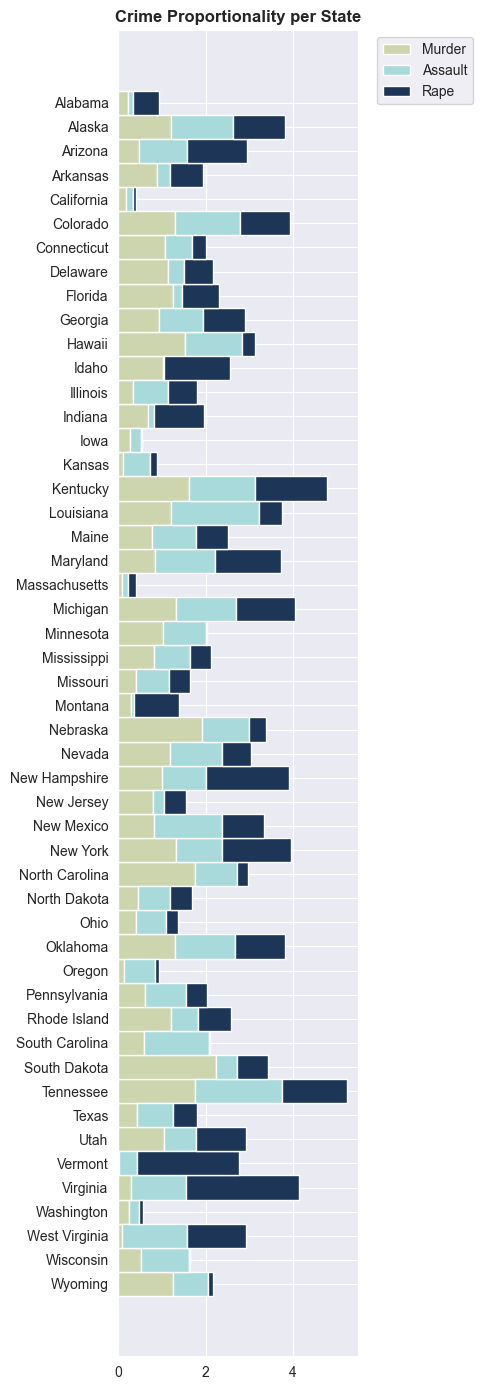

In [146]:
# Create the bottoms values that the next feature will start from.
height_1 = df2['Murder'] + df2['Assault']

# The positions of the bars on the x-axis
pos = list(range(1, df2.shape[0] + 1))

# Names of groups and bar width
names = df2.columns.tolist()
bar_width = 1

# Create subplot
_, ax = plt.subplots(figsize=(5, 14))
# Create the orinoco shaded bars
plt.barh(pos, df2['Murder'].values, color='#ccd5ae', edgecolor='white', height=bar_width)
# Create the charlotte shaded bars on top of the orinoco shaded bars
plt.barh(pos, df2['Assault'], left=df2['Murder'].values, color='#a8dadc', edgecolor='white', height=bar_width)
# Create the jelly bean shaded bars on top of the catalina blue bars
plt.barh(pos, df2['Rape'], left=height_1, color='#1d3557', edgecolor='white', height=bar_width)

# Custom Y axis
pos.reverse()
plt.yticks(pos, labels=df['City'])

labels_legend = ['Murder', 'Assault', 'Rape']

plt.title('Crime Proportionality per State', fontweight='bold')
plt.legend(labels=labels_legend, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### c) **What are the top 5 Urban Population size per City?**

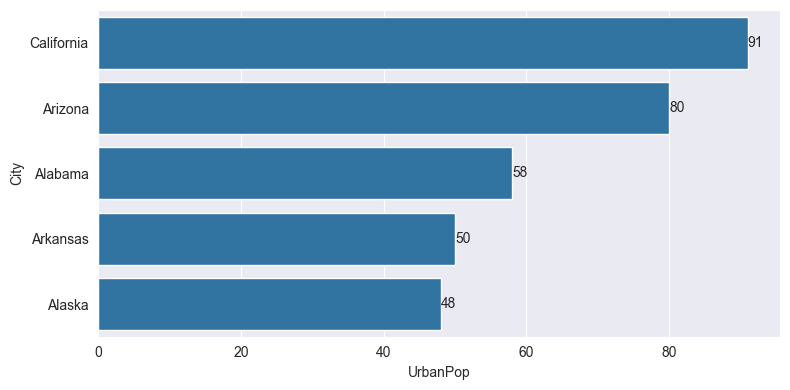

In [147]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(df.loc[:4, ['City', 'UrbanPop']].sort_values(ascending=False, by='UrbanPop'), y='City', x='UrbanPop', ax=ax)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

##### d) **How are the violent crimes distributed across American States?**

In [148]:
# View the columns and the data type of each feature of the geojson dataframe
geoData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        50 non-null     object  
 1   name      50 non-null     object  
 2   geometry  50 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.3+ KB


`NOTES`:

* A GeoJSON file is a format for encoding geographical data structures using JavaScript Object Notation (JSON). It is commonly used for representing geographic features, such as points, lines, and polygons, along with their associated attributes. (GitLab Docs, N.D.)

In [149]:
# Display the first 5 rows of the geoData
geoData.head()

,id,name,geometry
0,AL,Alabama,"POLYGON ((-87.3593 35.00118, -85.60668 34.9847..."
1,AK,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,AZ,Arizona,"POLYGON ((-109.0425 37.00026, -109.04798 31.33..."
3,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


In [150]:
# Display the first 5 rows of the state_code_df
state_code_df.head()

,Unnamed: 0,region,status,code
0,0,United States of America,Federal state,US
1,1,Alabama,State,AL
2,2,Alaska,State,AK
3,3,Arizona,State,AZ
4,4,Arkansas,State,AR


In [151]:
# Store the state_code_df with the region as the index, filtered to only having values with State and 
# State (officially Commonwealth) as values in the status column 
state_code_df = (
    state_code_df[
    (state_code_df['status'] == 'State') | (state_code_df['status'] == 'State (officially Commonwealth)')
].loc[:, ['region', 'code']].set_index('region')
)

# Create a dictionary from the single column dataframe
state_code_dct = {index: code for index, code in state_code_df['code'].items()}
state_code_dct

{'Alabama': 'AL',
 'Alaska': 'AK',
 'Arizona': 'AZ',
 'Arkansas': 'AR',
 'California': 'CA',
 'Colorado': 'CO',
 'Connecticut': 'CT',
 'Delaware': 'DE',
 'Florida': 'FL',
 'Georgia': 'GA',
 'Hawaii': 'HI',
 'Idaho': 'ID',
 'Illinois': 'IL',
 'Indiana': 'IN',
 'Iowa': 'IA',
 'Kansas': 'KS',
 'Kentucky': 'KY',
 'Louisiana': 'LA',
 'Maine': 'ME',
 'Maryland': 'MD',
 'Massachusetts': 'MA',
 'Michigan': 'MI',
 'Minnesota': 'MN',
 'Mississippi': 'MS',
 'Missouri': 'MO',
 'Montana': 'MT',
 'Nebraska': 'NE',
 'Nevada': 'NV',
 'New Hampshire': 'NH',
 'New Jersey': 'NJ',
 'New Mexico': 'NM',
 'New York': 'NY',
 'North Carolina': 'NC',
 'North Dakota': 'ND',
 'Ohio': 'OH',
 'Oklahoma': 'OK',
 'Oregon': 'OR',
 'Pennsylvania': 'PA',
 'Rhode Island': 'RI',
 'South Carolina': 'SC',
 'South Dakota': 'SD',
 'Tennessee': 'TN',
 'Texas': 'TX',
 'Utah': 'UT',
 'Vermont': 'VT',
 'Virginia': 'VA',
 'Washington': 'WA',
 'West Virginia': 'WV',
 'Wisconsin': 'WI',
 'Wyoming': 'WY'}

In [152]:
# Create a copy of the main dataframe
df3 = df.copy()
df3.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,20.1
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [153]:
# Create the column 'Code' in df3 based on the information in the 'City' column, using the map() method, by 
# passing the state_code_dct as an argument, containing a key of the city states in America, and the value being
# an abbreviation of the of the state
df3['Code'] = df3['City'].map(state_code_dct)
df3.head()

,City,Murder,Assault,UrbanPop,Rape,Code
0,Alabama,13.2,236,58,21.2,AL
1,Alaska,10.0,263,48,20.1,AK
2,Arizona,8.1,294,80,31.0,AZ
3,Arkansas,8.8,190,50,19.5,AR
4,California,9.0,276,91,40.6,CA


In [154]:
def crime_state_viz(Crime: str) -> None:
    """
    A function that creates an interactive choropleth map using the geodata dataframe and a copy of the main 
    dataframe. These two dataframe will need to have at least one single column with matching values in order
    to connect the two seperate dataframes. 

    Args:
        Crime: String
        A string representation of the nature of the violent crime
    
    Returns:
        None
    """
    fig = px.choropleth(df3, 
                        geojson=geoData
                        , locations='Code'
                        , featureidkey='properties.id'
                        , color=Crime
                        , color_continuous_scale="teal"
                        , hover_name='City'
                        , projection='albers usa'
                        , labels={Crime:f'{Crime} Count'})
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [155]:
# Store the list of violent crimes that are the features in the dataframe
list_of_criminal_offences = df.loc[:, ['Murder', 'Assault', 'Rape']].columns.tolist()

# Add a drop down widget onto the kernal
widgets.interactive(crime_state_viz, Crime=list_of_criminal_offences)

interactive(children=(Dropdown(description='Crime', options=('Murder', 'Assault', 'Rape'), value='Murder'), Ou…

`NOTES`:

* Based on the choropleth maps, we can see that the highest concentration of murders occur in the south east of America where you will find states such as Louisiana, Mississippi and Georgia. Coincidently, Regionally, the highest concentration of Black people in the U.S. in 2022 is in the South; more than half (56%) live there. (Moslimani, 2024). However, seeing two correlated features does not necessarily mean that we can infer that one variable causes another. 

* We can also see that there is a more spread area when it comes to Assault crimes as there is a greater concentration across the south of America, with Places such as California, Arizona, and New Mexico in the west, adding to the States in the East with their larger numbers comparatively. 

* Interestingly, we find that the highest Rape numbers come from the western coastline

#### 3. **Hypothesis Testing**

##### 3.1 **Null Hypothesis**:
___
* There is no linear relationship between the murder rates and the assault cases in the states of America.

##### 3.2 **Alternative Hypothesis**:
___
* There is a linear relationship between the murder rates and the assault cases in the states of America.

##### 3.3 **Significance Level**:
___
* Alpha is 5%. Therefore, ɑ = 0.05

##### 3.4 **Statistical Test**:
___

In [156]:
t_test_results = pearsonr(df3['Murder'], df3['Assault'])
significance_level = 0.05
print(f"P-value: {t_test_results.pvalue}")
print(f"Correlation_coeff: {t_test_results.statistic}\n")

if t_test_results.pvalue < significance_level:
    print(
        f'We reject null hypothesis. The test results are statistically significant at the '
        f'5% level and provide very strong evidence against the null hypothesis.'
    )
else:
    print('We Do not reject the null hypothesis')

P-value: 2.5957610014217712e-12
Correlation_coeff: 0.80187331172494

We reject null hypothesis. The test results are statistically significant at the 5% level and provide very strong evidence against the null hypothesis.


https://chatgpt.com/share/1cc4e82b-6f63-449c-a86d-b1643e79ebdb

___
## **Bibliography**
___

1. _Geeks For Geeks_. (2024), accessed 11 Jun 2024, Accessed at:
<https://www.student.unsw.edu.au/how-do-i-cite-electronic-sources>

2. Jules J. Berman. (2016) _Data Simplification_, Morgan Kaufmann is an imprint of Elsevier, Cambridge, MA, Available at:
<https://www.sciencedirect.com/topics/computer-science/pearson-correlation#:~:text=Pearson%20Correlation%20is%20a%20statistical,near%20zero%20indicates%20no%20correlation.>

3. Analytics Vidhya. (2024), _Difference Between Skewness and Kurtosis_, 29 July 2024, Accessed at: 
<https://www.analyticsvidhya.com/blog/2021/05/shape-of-data-skewness-and-kurtosis/> 

4. Zakaria Jaadi. (2023), _'When and Why to Standardize Your Data A simple guide on when it is necessary to standardize your data.'_, 29 July 2024, Accessed at:
<https://builtin.com/data-science/when-and-why-standardize-your-data#:~:text=Normalization%20is%20useful%20for%20when,is%20useful%20for%20normal%20distributions.>

5. GitLab Documentation. (no date) _GeoJSON files_. Available at:
<https://docs.gitlab.com/ee/user/project/repository/files/geojson.html#:~:text=A%20GeoJSON%20file%20is%20a,along%20with%20their%20associated%20attributes.> (Accessed: 01 August 2024)

6. Moslimani, M. (2024) _Facts About the U.S. Black Population_. Available at:
<https://www.pewresearch.org/social-trends/fact-sheet/facts-about-the-us-black-population/#:~:text=Regionally%2C%20the%20South%20is%20home,the%20total%20as%20of%202022.> (Accesed: 01 August 2024)